In [1]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.metrics import accuracy_score
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import shap
from sklearn.cluster import KMeans
sns.set()

import import_ipynb
from BankFindSearch import search

importing Jupyter notebook from BankFindSearch.ipynb


# Problem Statement

# Data Overview
The BankFind API's ```institutions``` endpoint contains over 27,000 financial institutions, including almost 5,000 that are active and insured by the FDIC. In this section, we will use some visualizations and clustering analysis as an introduction to the dataset. Specifically, we will try to classify these institutions by their size to get a sense of the scale of the data, and the disparities in sizes of different banks.

In [2]:
#we will use offices and assets as an indicator of an institutions size
variables = ['OFFICES','ASSET']

#Pull data from API using search according to specified variables
all_banks = search('institutions', 'ACTIVE:1',variables + ['NAME'])

Connection error


In [3]:
#Convert search result to pandas dataframe
frame = pd.DataFrame(all_banks, columns = variables)
names = pd.DataFrame(all_banks, columns = ['NAME'])
new_frame = frame.copy()
new_frame[variables[0]] = pd.to_numeric(frame[variables[0]], downcast = "float")
new_frame[variables[1]] = pd.to_numeric(frame[variables[1]], downcast = "float")

data = new_frame.dropna()
data_with_names = data.join(names)

#here we standardize the OFFICES and ASSETS data to avoid heavy bias towards ASSETS
#OFFICES data is in the thousands and ASSETS data is in the billions
scaler = preprocessing.StandardScaler()
s_data = scaler.fit_transform(data)
scaled_data = pd.DataFrame(s_data, columns = ['OFFICES', 'ASSET'])

### Cluster Analysis

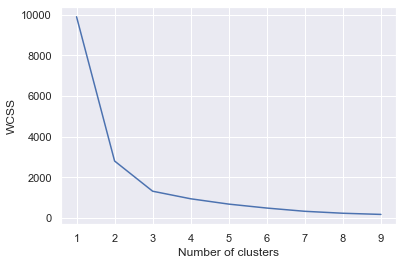

In [4]:
#use elbow method to determine optimal number of clusters
wcss = []
for i in range(1,10):
    kmeans = KMeans(i)
    kmeans.fit(scaled_data)
    wcss.append(kmeans.inertia_)
plt.xlabel("Number of clusters")
plt.ylabel("WCSS")
plt.plot(range(1,10), wcss)

The elbow method helps us to determine the optimal number of clusters to use in our analysis. The optimal number of clusters should both minimize the within-cluster sum of squares (WCSS - y axis on graph above), and keep our number of clusters low. The 'elbow method' allows us to find this optimal point, by seeing where the 'elbow' is on the graph shown above. This number appears to be at 3, since after 3 clusters, adding additional clusters does not significantly decrease the WCSS. Therefore, we will use 3 clusters in our analysis

In [30]:
#perform cluster analysis
kmeans = KMeans(3)
kmeans.fit(data)
clusters = kmeans.fit_predict(scaled_data)
data_clusters = data.copy()
data_clusters['Cluster'] = clusters

data_names_clusters = data_with_names.join(data_clusters['Cluster'])
data_x = data_clusters[variables[0]]
data_y = data_clusters[variables[1]]

In [31]:
#a function we will use to plot graphs and avoid repeating code 
def plot_banks(lim=False, xlim=0, ylim=0, lines=False, x = 0, y = 0):
    dash_line_color = "black"
    if lim:
        plt.xlim(0,xlim)
        plt.ylim(0,ylim*10**9)
    plt.scatter(data_x,data_y, c = data_clusters['Cluster'], cmap='rainbow')
    if lines:
        plt.hlines(y*10**9,0,x,color=dash_line_color, linestyles = 'dashed')
        plt.vlines(x,0,y*10**9,color=dash_line_color, linestyles = 'dashed')
    plt.xlabel(variables[0], fontsize=20)
    plt.ylabel(variables[1], fontsize=20)
    plt.show()

### Plots and Cluster Analysis Results

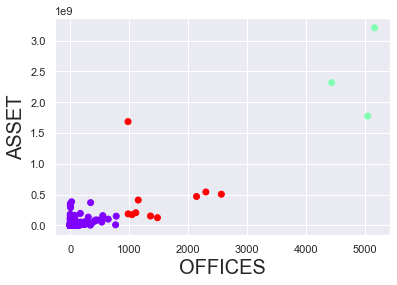

In [32]:
plot_banks()

#### Description
Above is a scatterplot of all active institutions in the FDIC's database plotted based on the number of offices and the number of assets (in Billions of dollars). The three different colors show the results of our cluster analysis

In [79]:
cluster1 = []
cluster2 = []
cluster3 = []
for i in range(0,len(data_names_clusters)):
    cluster =  data_names_clusters.iloc[i, 3]
    name = data_names_clusters.iloc[i, 2]
    if cluster == 0:
        cluster3.append(name)
    elif cluster == 1:
        cluster1.append(name)
    elif cluster == 2:
        cluster2.append(name)

#### Clustering Results

We obtained 3 clusters:
1. **The largest banks** (large assets and high number of offices) - this is the smallest cluster, containing only three institution (shown below). While all three of these banks are very large, JPMorgan Chase Bank beats all others by fairly good margins in both number of offices and assets held

In [80]:
#print the three banks in cluster 1
for bank in cluster1:
    print(bank)

Bank of America, National Association
Wells Fargo Bank, National Association
JPMorgan Chase Bank, National Association


2.**Large but less dominate banks** (lots of offices, but less assets than the largest banks) - This cluster contains 10 banks that share the property of having many offices and much higher than average assets, though not nearly to the extent of cluster 1. One note here is that one bank in particular stands out within this cluster - Citibank has more assets than the rest of the cluster, nearly reaching the levels of the largest banks - however, it has much less offices compared to banks in cluster 1 which likely keeps it in cluster 2. Besides this bank, 3 banks in cluster 2 also stand out for their high number of offices - PNC, US Bank, and Truist. 

In [90]:
#print banks in cluster 2
for bank in cluster2:
    print(bank)

Regions Bank
KeyBank National Association
TD Bank, National Association
Citizens Bank, National Association
PNC Bank, National Association
U.S. Bank National Association
The Huntington National Bank
Fifth Third Bank, National Association
Citibank, National Association
Truist Bank


3. **Medium-large to small banks** - this cluster contains the VAST majority of institutions - in fact, 99.7% of all institutions are in this cluster!! - this result really illustrates the extent to which the top tier of banks dominate most everyone in terms of their size. 

In [91]:
#print the proportion of all banks found in cluster 3
print(len(cluster3) / len(data))

0.9973721447341823


#### Zooming into Cluster 1

To further illustrate the size of cluster 3, we can zoom in the bottom left portion of the graph below to show cluster 3 more clearly. The black dashed-line indicates the section we are zooming into for each successive graph.

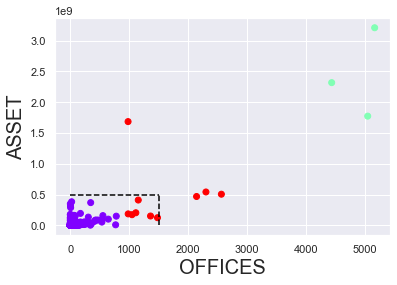

In [92]:
plot_banks(lines=True, x=1500, y=.5)

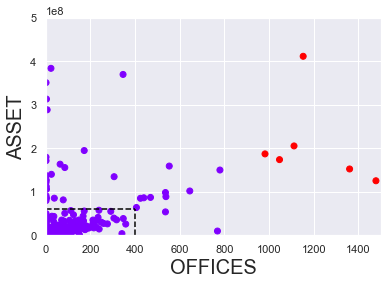

In [93]:
#now zoom in
plot_banks(True, 1500, .5, True, 400, .06)

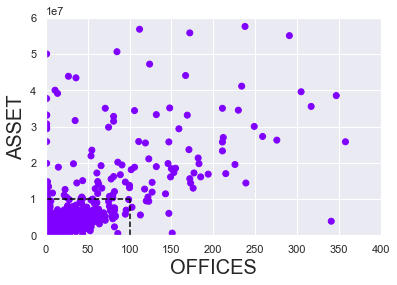

In [94]:
#zoom in again
plot_banks(True, 400, .06, True, 100, .01)

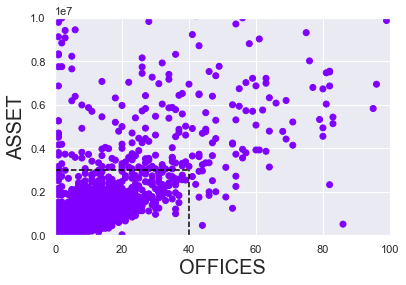

In [95]:
#and again
plot_banks(True, 100, .01, True, 40, .003)

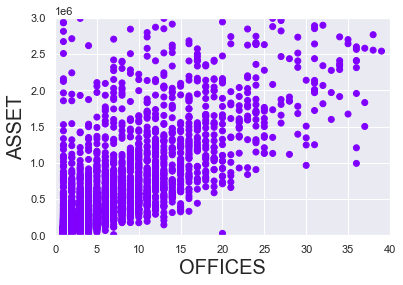

In [96]:
#and zoom one more time!
plot_banks(True, 40, .003)

### Summary 

# Data Analysis

In [97]:
flag_cols = ['CB', 'CHRTAGNT',  'CFPBFLAG', 'FEDCHRTR',
            'FORM31', 'HCTMULT', 'IBA', 'INSCOML', 'INSSAVE', 'MDI_STATUS_DESC', 'REGAGNT', 'SPECGRP',  'STCHRTR', 'SUBCHAPS',
            'TRACT', 'TRUST']
numeric_cols = ['ASSET', 'DEP', 'EQ', 'OFFICES']
r = search("institutions", 'ACTIVE:1',  flag_cols + numeric_cols + ['ROA'])

Connection error


In [99]:
flag_frame = pd.DataFrame(r, columns = flag_cols + ['ROA'])
numeric_frame = pd.DataFrame(r, columns = numeric_cols)
flag_data = flag_frame.dropna()
numeric_data = numeric_frame.dropna()

In [100]:
flag_cdata = flag_data.drop('SPECGRP', axis = 1)
flag_cdata['CHRTAGNT'] = flag_data['CHRTAGNT'].map(lambda x: 1 if x == 'STATE' else 0)
flag_cdata['MDI_STATUS_DESC'] = flag_data['MDI_STATUS_DESC'].map(lambda x: 0 if x == "NONE" else 1)
flag_cdata['REGAGNT'] = flag_data['REGAGNT'].map(lambda x: 0 if x == "FDIC" else 1)
flag_cdata['COMLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 4 else 0)
flag_cdata['AGRS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 2 else 0)
flag_cdata['CONLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 6 else 0)
flag_cdata['CCS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 3 else 0)
flag_cdata['INTLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 1 else 0)
flag_cdata['MRLS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 5 else 0)
flag_cdata['OOBS'] = flag_data['SPECGRP'].map(lambda x: 1 if x == 9 else 0)
flag_cdata['CB'] = flag_data['CB'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['FORM31'] = flag_data['FORM31'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['HCTMULT'] = flag_data['HCTMULT'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['TRACT'] = flag_data['TRACT'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['TRUST'] = flag_data['TRUST'].map(lambda x: 1 if x == '1' else 0)
flag_cdata['SUBCHAPS'] = flag_data['SUBCHAPS'].map(lambda x: 1 if x == '1' else 0)

In [101]:
numeric_cdata= numeric_data.copy()
numeric_cdata['ASSET'] = pd.to_numeric(numeric_data['ASSET'], downcast = "float")
numeric_cdata['DEP'] = pd.to_numeric(numeric_data['DEP'], downcast = "float")
numeric_cdata['EQ'] = pd.to_numeric(numeric_data['EQ'], downcast = "float")
numeric_cdata['OFFICES'] = pd.to_numeric(numeric_data['OFFICES'], downcast = "float")

In [102]:
#scale our quantitative data
#this data is important to scale so variables of much higher magnitude don't receive extra weight
#note that we do no do this for the indicator variables since this data is inherently low in magnitude...
#...and doing so would also make weights much harder to interpret

scaler = preprocessing.StandardScaler()
scaled_num_data = scaler.fit_transform(numeric_cdata)
scaled_numeric_data = pd.DataFrame(scaled_num_data, columns = numeric_cols)

In [103]:
#combine the scaled numertic data with the categorical data from Model 2
join_data = scaled_numeric_data.join(flag_cdata)

#drop any new missings values
joined_cdata = join_data.dropna()

In [104]:
#shuffle data and partition inputs and targets
cdata_shuff =  joined_cdata.sample(frac=1, random_state=87)
inputs = cdata_shuff.drop('ROA', axis = 1)

#here, ROA is converted to a binary indicator variable 
#target is 1 if ROA > 1%, 0 otherwise
#1% is chosen to balance the data with 1s and 0s
#choosing >0% (postitive/negative)indicator, while more intuitive, would lead to 96-4 split, very unbalanced
targets = [0 if x < 1  else 1 for x in cdata_shuff['ROA']]

In [105]:
#check for balance 
sum(targets) / len(targets)

0.5878775592945469

In [106]:
#split into train and test datasets
train, test = train_test_split(inputs, test_size=0.10, shuffle=False)

train_targets =targets[:len(train)]
test_targets = targets[len(train):]

In [107]:
#load into xgb matrix
dtrain = xgb.DMatrix(train, label=train_targets)
dtest = xgb.DMatrix(test, label=test_targets)

#execute xgb training
param = {'max_depth': 2, 'eta':1.2, 'objective':'binary:logistic' }
num_round = 10
bst = xgb.train(param, dtrain, num_round)

[15:57:33] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


In [108]:
#generate predictions for test dataset
preds = bst.predict(dtest)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

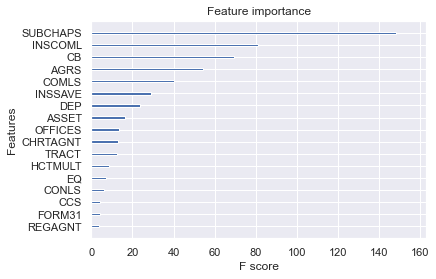

In [109]:
#plot default feature importance - not as good as shap output
xgb.plot_importance(bst, importance_type = 'gain', show_values = False)

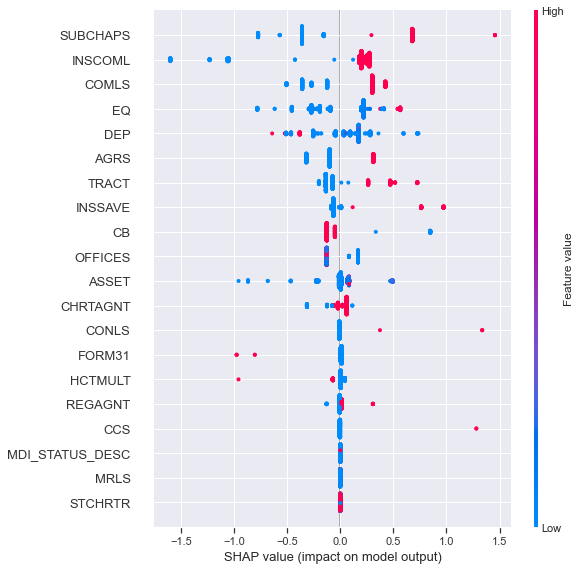

In [110]:
#print shap output - very helpful for understanding variable importance
shape_values = shap.TreeExplainer(bst).shap_values(test)
shap.summary_plot(shape_values, test)

In [111]:
#print both train and test accuracy
train_preds = [1 if x >= .5 else 0 for x in bst.predict(dtrain)]
test_preds = [1 if x >= .5 else 0 for x in preds]
train_accuracy = accuracy_score(train_targets, train_preds)
test_accuracy = accuracy_score(test_targets, test_preds)
print(f'Train accuracy: {train_accuracy}\nTest accuracy: {test_accuracy}')

Train accuracy: 0.7019599008785763
Test accuracy: 0.7064777327935222
